In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from pathlib import Path
from scipy.special import rel_entr, kl_div
from scipy.stats import wasserstein_distance

parameter_names = ['cpa', 'pwr1par', 'pwr2par', 'pwr1perr', 'pwr2perr'] 
PARAMETERS_MIN = np.array([100., 0.4, 0.4, 0.4, 0.4]) 
PARAMETERS_MAX = np.array([870., 1.7, 1.7, 2.3, 2.3]) 

## Relevant functions from utils.py
Can't just import utils since path to data is different than utils.py

In [2]:
def index_mcmc_runs(file_version):
    """Make a list of combinations for which we want to run MCMC."""
    if file_version == '2023':
        experiments = ['AMS02_H-PRL2021', 'PAMELA_H-ApJ2013', 'PAMELA_H-ApJL2018']
        dfs = []
        for experiment_name in experiments:
            filename = f'../../data/2023/{experiment_name}_heliosphere.dat'
            df = index_experiment_files(filename) 
            df['experiment_name'] = experiment_name
            df['filename_heliosphere'] = filename
            dfs.append(df)
        df = pd.concat(dfs, axis=0, ignore_index=0)

    elif file_version == '2024':
        filename = f'../../data/2024/yearly_heliosphere.dat'
        df = read_experiment_summary(filename)
        df['experiment_name'] = 'yearly'
        df['filename_heliosphere'] = filename

    else: raise ValueError(f"Unknown file_version {file_version}. Must be '2023' or '2024'.")

    return df

def read_experiment_summary(filename) -> pd.DataFrame:
    """
    Read .dat filename that describes experimental conditions during time intervals.
    """
    if '2023' in filename: file_version = '2023'
    elif '2024' in filename: file_version = '2024'
    else: raise ValueError(f"Unknown file_version {file_version}. Must be '2023' or '2024'.")

    if file_version == '2023':
        # Header reads "time interval; alpha avg; cmf avg; vspoles avg; alpha std; cmf std; vspoles std"
        df = pd.read_csv(filename, sep=' ', skiprows=1, names=['interval', 'alpha', 'cmf', 'vspoles', 'alpha_std', 'cmf_std', 'vspoles_std'])
    
        # Parse interval
        df['beginning'] = df.interval.apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y%m%d'))
        df['ending'] = df.interval.apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y%m%d'))

    elif file_version == '2024':
        # Header reads "time interval; alpha avg; cmf avg; vspoles avg; alpha std; cmf std; vspoles std; polarity"
        df_full = pd.read_csv(filename, sep=' ', skiprows=1, names=['interval', 'alpha', 'cmf', 'vspoles', 'alpha_std', 'cmf_std', 'vspoles_std', 'polarity'])

        # only use the neg or neg,pos polarities column, and change all to be neg
        df = df_full[df_full['polarity'].str.contains('neg')].copy(deep=True)
        df['polarity'] = 'neg'

    return df

def index_experiment_files(filename)->pd.DataFrame:
    """Create list of experiments that need to be done. 
    Note this is only needed for file_version '2023'
    filename = f'../../data/2023/{EXPERIMENT_NAME}_heliosphere.dat'
    """
    df = read_experiment_summary(filename)
    # The datasets to be fitted are: PAMELA_H-ApJ2013, PAMELA_H-ApJL2018, and AMS02_H-PRL2021.
    # You should use the neg models for data files up to February 2015, and the pos models for data files from October 2013.
    # So, between October 2013 and February 2015, the data files should be fitted independently with both neg and pos models.
    # All PAMELA files are before February 2015, so only neg models for them.
    # For AMS02 files, 20130925-20131021.dat is the first file to be fitted with pos models, while 20150124-20150219.dat is the last file to be fitted with neg models.
    # 
    # For PAMELA_H-ApJL2018, the files 20130928-20131025.dat, 20131121-20131219.dat, and 20140115-20140211.dat should be fit independently with both neg and pos models.

    dfneg = df[df.beginning < pd.to_datetime('March 1 2015')].copy(deep=True)
    dfneg['polarity'] = 'neg'

    dfpos = df[df.ending >= pd.to_datetime('October 1 2013')].copy(deep=True)
    dfpos['polarity'] = 'pos'

    # rval = pd.concat([dfneg, dfpos], axis=0, ignore_index=True)
    rval = dfneg # Only fitting negative models for now.
    
    return rval

def get_distance(hist_0, hist_1, metric='mae'):
    """
    Compute distance between two histograms.
    """
    num_bins = len(hist_0)
    if len(hist_1) != num_bins:
        raise ValueError(f"Histograms must have the same number of bins. {len(hist_0)} != {len(hist_1)}")
    
    if metric == 'mae':
        return np.abs(hist_0 - hist_1).sum() / num_bins
    elif metric == 'mse':
        return ((hist_0 - hist_1) ** 2).sum() / num_bins
    elif metric == 'kl':
        return kl_div(hist_0, hist_1).sum()
    elif metric == 'wasserstein':
        return wasserstein_distance(hist_0, hist_1)
    else:
        raise ValueError(f"Unknown metric {metric}.")

# Now calculate the average over all 0-132 runs

In [3]:
# Parameters (change me!)
train_fractions = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
data_version=['d1', 'd2'] # 'd1', 'd2'
bootstrap=['b0', 'b1'] # 'b0' or 'b1'
model_version=['init1', 'init2'] # 'init1' or 'init2'
hmc_run = ['hmc1', 'hmc2'] # 'hmc1' or 'hmc2'
hmc_version='v31'
regularizer = '1e-4' # '1e-1', '1e-2', '1e-3', '1e-4', '1e-5', '1e-6'
metric = 'mae' # mae, mse, kl, wasserstein
data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}_{regularizer}"
data_bootstrap_model_hmc_identifier_1 = f"{data_version[1]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}_{regularizer}"
data_bootstrap_model_hmc_identifier_2 = f"{data_version[0]}_{bootstrap[1]}_{model_version[1]}_{hmc_run[0]}_{regularizer}"
data_bootstrap_model_hmc_identifier_3 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[1]}_{regularizer}"
output_file = f'../../../results/{hmc_version}/plots/{data_bootstrap_model_hmc_identifier_0}_vs_all_{metric}_distance_all_intervals.csv'
write_new_file = False
print(f"{write_new_file}: Writing to {output_file}.")

# Calculate the distance, but take average over the 133 time intervals
df = index_mcmc_runs(file_version='2023')

# Only keep 'neg' polarity
df = df[df.polarity == 'neg'].copy(deep=True)
print(df.shape)

False: Writing to ../../../results/v31/plots/d1_b1_init1_hmc1_1e-4_vs_all_mae_distance_all_intervals.csv.


(133, 12)


In [4]:
num_bins = 30

# Create a file to write the distance
if write_new_file:
    with open(output_file, 'w') as f:
        f.write(f"train_size_fraction,param,df_index,{metric}_distance_01,{metric}_distance_02,{metric}_distance_03\n")

    # Calculate the k;_divergence for each parameter and train size
    for i, train_size_fraction in enumerate(train_fractions):
        print(f"\n-----------------\nProcessing train size fraction {train_size_fraction}...")
        results_dir_hmc_0 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_0}_{train_size_fraction}/"
        results_dir_hmc_1 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_1}_{train_size_fraction}/"
        results_dir_hmc_2 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_2}_{train_size_fraction}/"
        results_dir_hmc_3 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_3}_{train_size_fraction}/"

        for j, param in enumerate(parameter_names):
            # Load the samples from each hmc run, get average per parameter and stdev
            print(f"Processing parameter {param}...")
            for idx in range(df.shape[0]):
                # Load info from the df for index idx
                exp_name = df.experiment_name.iloc[idx]
                interval = df.interval.iloc[idx]
                polarity = df.polarity.iloc[idx]

                # They are stored like this: f'{results_dir_hmc}.0/samples_{idx}_{df.experiment_name}_{df.interval}_{df.polarity}.csv'
                # csv file has no headersd, but samples are in this order: ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
                try:
                    hmc_0_samples = pd.read_csv(f'{results_dir_hmc_0}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
                    hmc_1_samples = pd.read_csv(f'{results_dir_hmc_1}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
                    hmc_2_samples = pd.read_csv(f'{results_dir_hmc_2}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
                    hmc_3_samples = pd.read_csv(f'{results_dir_hmc_3}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
                except FileNotFoundError:
                    print(f"File not found for index {idx}, experiment {exp_name}, interval {interval}, polarity {polarity}. Skipping.")
                    continue
                
                # Get the samples
                hmc_0_samples.columns = parameter_names
                hmc_1_samples.columns = parameter_names
                hmc_2_samples.columns = parameter_names
                hmc_3_samples.columns = parameter_names

                samples_0 = hmc_0_samples[param].values
                samples_1 = hmc_1_samples[param].values
                samples_2 = hmc_2_samples[param].values
                samples_3 = hmc_3_samples[param].values

                # Plot the samples with same bins
                # Use global binning after lab meeting conversation 4/9/2025
                min = PARAMETERS_MIN[j] 
                max = PARAMETERS_MAX[j]

                # Create histograms and plot
                hist_0, bins = np.histogram(samples_0, bins=num_bins, range=(min, max), density=True)
                hist_1, bins = np.histogram(samples_1, bins=num_bins, range=(min, max), density=True)
                hist_2, bins = np.histogram(samples_2, bins=num_bins, range=(min, max), density=True)
                hist_3, bins = np.histogram(samples_3, bins=num_bins, range=(min, max), density=True)

                # Normalize the histograms
                hist_0 /= hist_0.sum()
                hist_1 /= hist_1.sum()
                hist_2 /= hist_2.sum()
                hist_3 /= hist_3.sum()

                # Calculate distance as MAE between bins
                distance_01 = get_distance(hist_0, hist_1, metric=metric)
                distance_02 = get_distance(hist_0, hist_2, metric=metric)
                distance_03 = get_distance(hist_0, hist_3, metric=metric)

                # Write the distance for this train_size_fraction, parameter, and index to a file
                with open(output_file, 'a') as f:
                    f.write(f"{train_size_fraction},{param},{idx},{distance_01},{distance_02},{distance_03}\n")

In [5]:
distance_versions = ['01', '02', '03']

avg_distances = {} # All 0-132 intervals
std_distances = {}

avg_distances_pamela = {} # First 0-50 intervals
std_distances_pamela = {}

avg_distances_ams02 = {} # Last 51-132 intervals
std_distances_ams02 = {}

for dist_version in distance_versions:
    for param in parameter_names:
        avg_distances[f'{param}_{dist_version}'] = []
        std_distances[f'{param}_{dist_version}'] = []

        avg_distances_pamela[f'{param}_{dist_version}'] = []
        std_distances_pamela[f'{param}_{dist_version}'] = []

        avg_distances_ams02[f'{param}_{dist_version}'] = []
        std_distances_ams02[f'{param}_{dist_version}'] = []

    # Read the distance value from the file
    df = pd.read_csv(output_file)
    for param in parameter_names:
        df_param = df[df.param == param]
        df_param_pamela = df_param[df_param.df_index > 50]
        df_param_ams02 = df_param[df_param.df_index <= 50]

        # Get the average distance for each train size
        distance = df_param.groupby('train_size_fraction')[f'{metric}_distance_{dist_version}']
        distance_pamela = df_param_pamela.groupby('train_size_fraction')[f'{metric}_distance_{dist_version}']
        distance_ams02 = df_param_ams02.groupby('train_size_fraction')[f'{metric}_distance_{dist_version}']

        avg_distances[f'{param}_{dist_version}'] = distance.mean().values
        std_distances[f'{param}_{dist_version}'] = distance.std().values

        avg_distances_pamela[f'{param}_{dist_version}'] = distance_pamela.mean().values
        std_distances_pamela[f'{param}_{dist_version}'] = distance_pamela.std().values

        avg_distances_ams02[f'{param}_{dist_version}'] = distance_ams02.mean().values
        std_distances_ams02[f'{param}_{dist_version}'] = distance_ams02.std().values

print(avg_distances)
print(std_distances)

{'cpa_01': array([0.05622494, 0.03827335, 0.01262392, 0.00712658, 0.00349533,
       0.00567212, 0.00552138, 0.00357625, 0.00387652, 0.00611467,
       0.00708638, 0.00491723, 0.00431897]), 'pwr1par_01': array([0.05622133, 0.04171394, 0.01752027, 0.0036049 , 0.00213901,
       0.00234889, 0.00193527, 0.00204443, 0.00201813, 0.00236223,
       0.00158665, 0.00161515, 0.00163172]), 'pwr2par_01': array([0.0495306 , 0.03772591, 0.01325393, 0.00402225, 0.00260752,
       0.00362546, 0.0032166 , 0.00309143, 0.00334771, 0.00382682,
       0.0037968 , 0.00295341, 0.00258606]), 'pwr1perr_01': array([0.05413789, 0.04175855, 0.01833291, 0.00300483, 0.00140276,
       0.0023488 , 0.00155239, 0.00150671, 0.00142275, 0.00129125,
       0.00112394, 0.00201335, 0.00136123]), 'pwr2perr_01': array([0.05662341, 0.03629724, 0.01732968, 0.0038475 , 0.00236822,
       0.00286602, 0.0035195 , 0.0021591 , 0.00257512, 0.00320164,
       0.00310637, 0.00223585, 0.00195124]), 'cpa_02': array([0.05455486, 0.03782

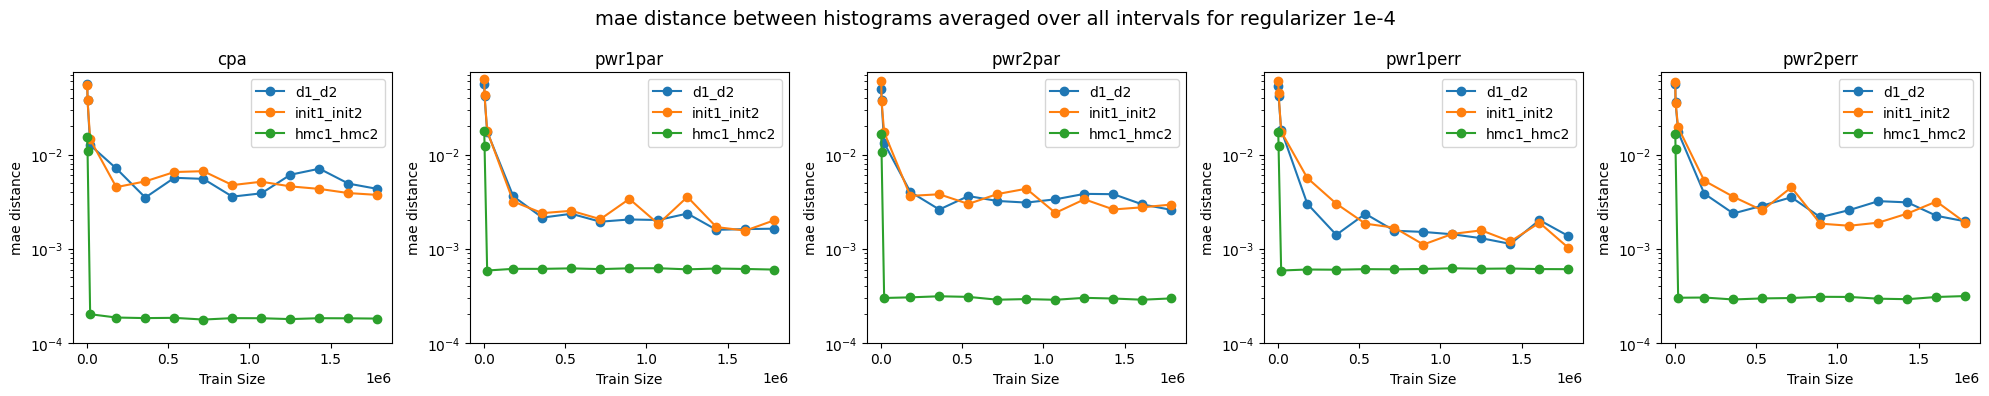

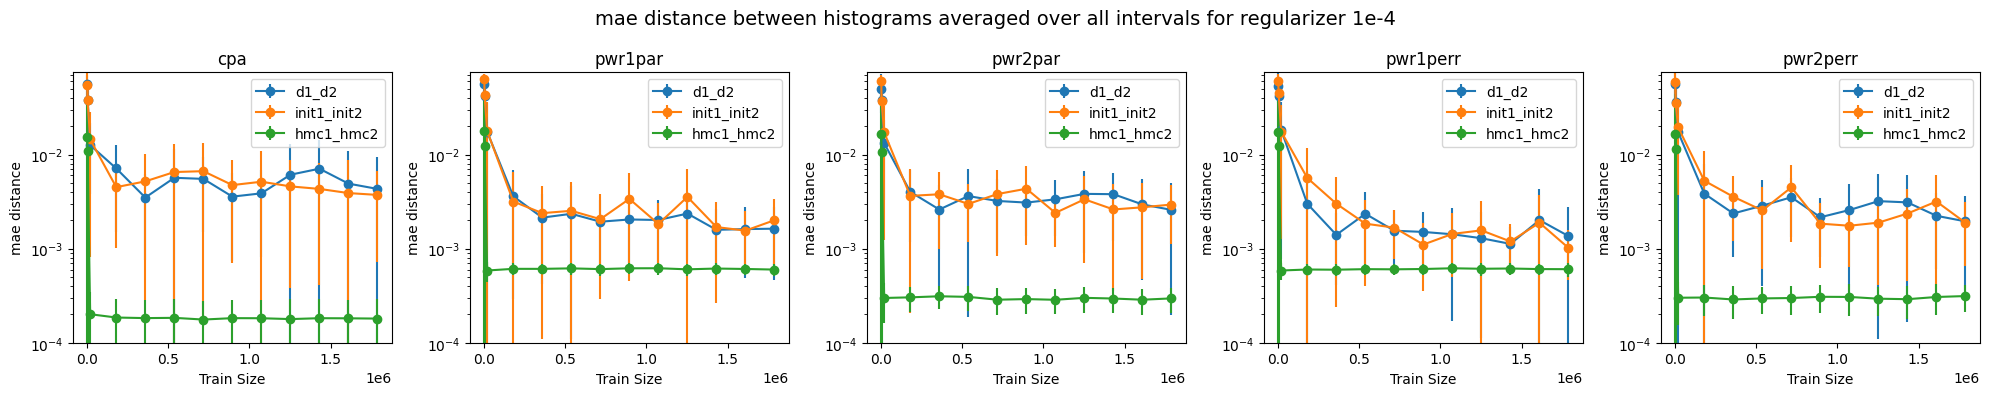

In [15]:
data_train_fractions = np.array(train_fractions) * 1_788_892 # Scale to the number of data points in the full dataset
distance_versions = ['01', '02', '03']
distance_versions_long_name = ['d1_d2', 'init1_init2', 'hmc1_hmc2']

# Let's make a 1 x 5 grid of subplots, where each plot is the distance for each parameter over all the train sizes
plt.figure(figsize=(20, 4))
plt.suptitle(f"{metric} distance between histograms averaged over all intervals for regularizer {regularizer}", fontsize=14)

# Plot the KL divergences
for i, param in enumerate(parameter_names):
    plt.subplot(1, 5, i+1)
    for j, dist_version in enumerate(distance_versions):
        plt.plot(data_train_fractions, avg_distances[f'{param}_{dist_version}'], marker='o', label=f'{distance_versions_long_name[j]}')
    plt.title(param)
    # plt.ylim(0, 0.06)
    plt.xlabel('Train Size')
    plt.ylabel(f'{metric} distance')
    plt.ylim(0.0001, 0.075)
    plt.yscale('log')
    plt.legend()

plt.tight_layout()
plt.savefig(f'../../../results/{hmc_version}/plots/{data_bootstrap_model_hmc_identifier_0}_vs_all_average_{metric}_distance.png', dpi=300)
plt.show()

# Let's make a 1 x 5 grid of subplots, where each plot is the distance for each parameter over all the train sizes
plt.figure(figsize=(20, 4))
plt.suptitle(f"{metric} distance between histograms averaged over all intervals for regularizer {regularizer}", fontsize=14)

# Plot the KL divergences
for i, param in enumerate(parameter_names):
    plt.subplot(1, 5, i+1)
    for j, dist_version in enumerate(distance_versions):
        plt.errorbar(data_train_fractions, avg_distances[f'{param}_{dist_version}'], yerr=std_distances[f'{param}_{dist_version}'], marker='o', label=f'{distance_versions_long_name[j]}')
    plt.title(param)
    plt.xlabel('Train Size')
    plt.ylabel(f'{metric} distance')
    plt.ylim(0.0001, 0.075)
    plt.yscale('log')
    plt.legend()

plt.tight_layout()
# plt.savefig(f'../../../results/{hmc_version}/plots/{data_bootstrap_model_hmc_identifier_0}_vs_all_average_errorbars_{metric}_distance.png', dpi=300)
plt.show()

Split analysis between all intervals, AMS, and PAMELA

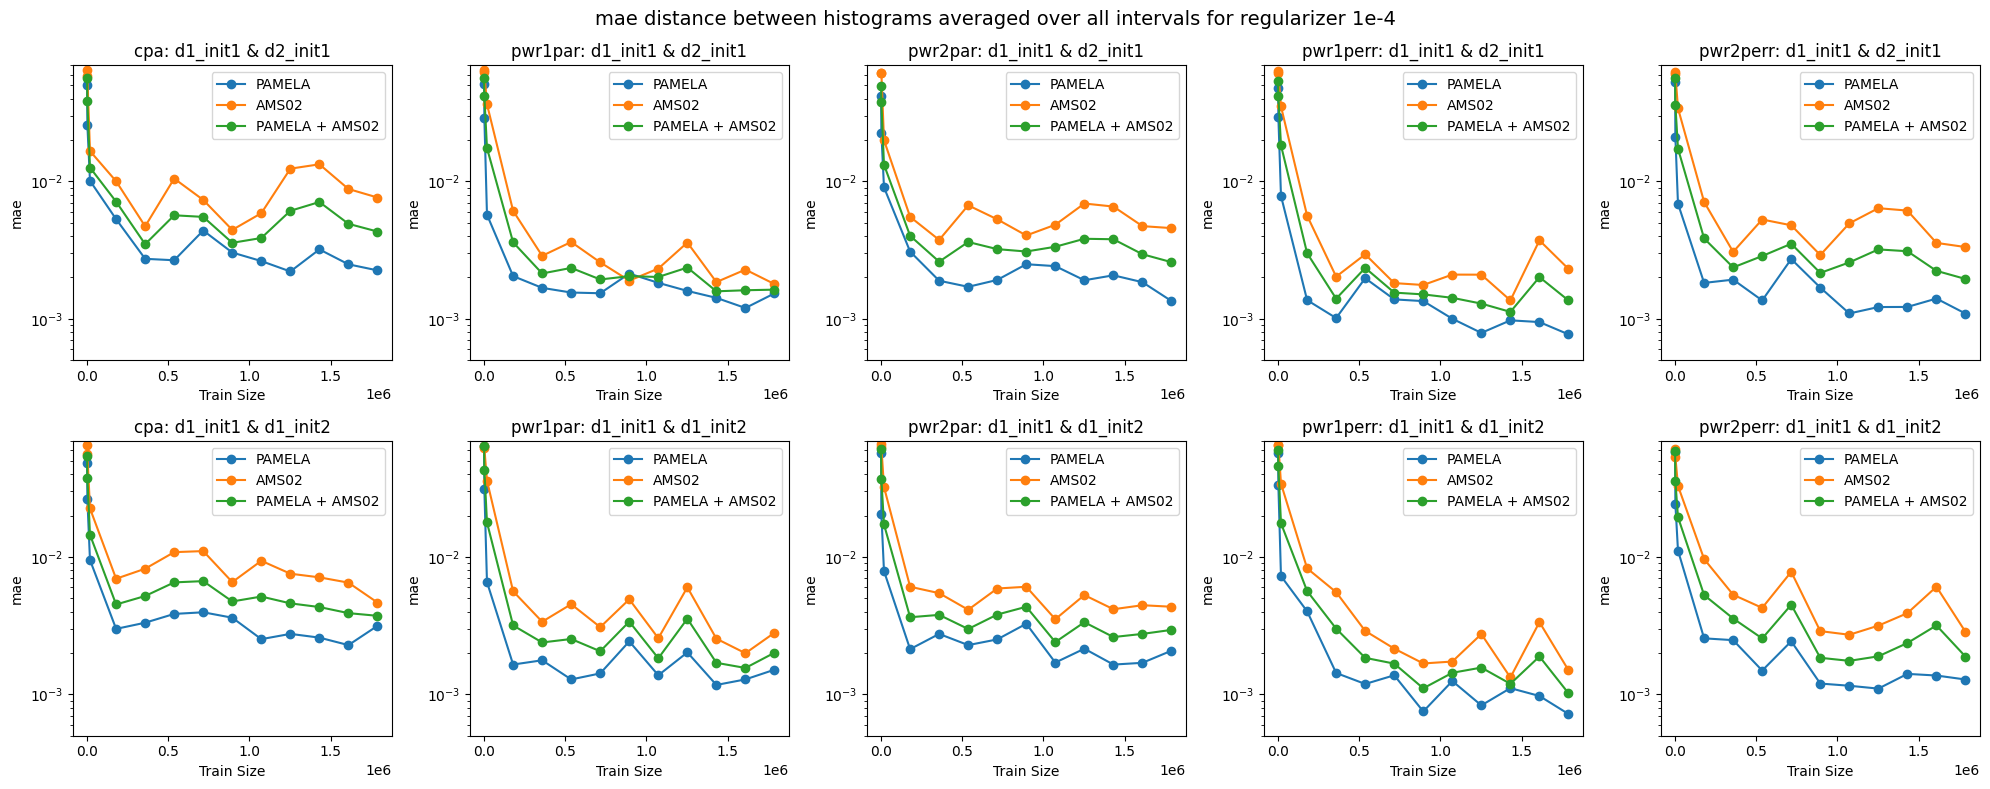

In [14]:
data_train_fractions = np.array(train_fractions) * 1_788_892 # Scale to the number of data points in the full dataset
distance_versions = ['01', '02'] #, '03']
distance_versions_long_name = ['d1_init1 & d2_init1', 'd1_init1 & d1_init2'] #, 'd1_init1_hmc1 & d1_init1_hmc2']
intervals = ['PAMELA', 'AMS02', 'PAMELA + AMS02']

# Make a 5 column x 3 row plot, where the top is avg over all time intervals, then AMS, then PAMELA
plt.figure(figsize=(20, 8))
plt.suptitle(f"{metric} distance between histograms averaged over all intervals for regularizer {regularizer}", fontsize=14)
for i, dist_version in enumerate(distance_versions): 
    for j, param in enumerate(parameter_names):
        for interval in intervals:
            subplot_num = i * len(parameter_names) + j + 1
            plt.subplot(len(distance_versions), len(parameter_names), subplot_num)

            if interval == 'PAMELA + AMS02':
                plt.plot(data_train_fractions, avg_distances[f'{param}_{dist_version}'], marker='o', label='PAMELA + AMS02')
            elif interval == 'PAMELA':
                plt.plot(data_train_fractions, avg_distances_pamela[f'{param}_{dist_version}'], marker='o', label='PAMELA')
            elif interval == 'AMS02':
                plt.plot(data_train_fractions, avg_distances_ams02[f'{param}_{dist_version}'], marker='o', label='AMS02')

            plt.title(f'{param}: {distance_versions_long_name[i]}')
            plt.ylim(0.0005, 0.07)
            plt.xlabel('Train Size')
            plt.ylabel(f'{metric}')
            plt.yscale('log')
            plt.legend()

plt.tight_layout()
plt.savefig(f'../../../results/{hmc_version}/plots/{data_bootstrap_model_hmc_identifier_0}_vs_all_average_{metric}_distance_pamela_ams.png', dpi=300)
plt.show()

Examine across time intervals for one train size

In [ ]:
# train_size_fraction = '1.0'

# # Plot for one train size the average and std of the distances over time intervals 0-132
# avg_distances = {}
# for param in parameter_names:
#     avg_distances[param] = []

# # Read the distance value from the file
# df = pd.read_csv(output_file)
# df = df[df.train_size_fraction == f'{train_size_fraction}'].copy(deep=True)
# for param in parameter_names:
#     df_param = df[df.param == param]

#     # Get the average distance for each train size
#     avg_distance = df_param.groupby('df_index')[f'{metric}_distance'].mean().values
#     avg_distances[param] = avg_distance

# # plot it
# plt.figure(figsize=(20, 4))
# plt.suptitle(f"{metric} distance between models {data_bootstrap_model_hmc_identifier_0} and {data_bootstrap_model_hmc_identifier_1} for {train_size_fraction * 100}% train size: {train_size_fraction * 1_788_892}", fontsize=14)

# # Plot the distance against df_index
# for i, param in enumerate(parameter_names):
#     plt.subplot(1, 5, i+1)
#     plt.scatter(range(len(avg_distances[param])), avg_distances[param])
#     plt.title(param)
#     plt.xlabel('Interval Index')
#     plt.ylabel(f'{metric} distance')

# plt.tight_layout()
# plt.savefig(f'../../../results/{hmc_version}/plots/{data_bootstrap_model_hmc_identifier_0}_vs_{data_bootstrap_model_hmc_identifier_1}_{metric}_distance_{train_size_fraction}_across_intervals.png', dpi=300)
# plt.show()